<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Project 3: Web APIs & NLP
### Reddit Scams: Are We Vulnerable?
---

## 2. Data Cleaning

### 2.1 Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 2.2 Import scraped dataset

In [ ]:
df = pd.read_csv('imputed_data.csv')
df.head()

,age,height,weight,bmi,yrssmok,packday,yrsquit,sleep_hours,health_status,phys_health_not_good,...,asthma_status,race_ethnicity,sex,education,income,smoker_status,e_cig_smoker,binge_drinker,heavy_drinker,chd_mi
0,80.0,1.734514,84.290327,28.075576,0.0,0.0,0.0,8.0,2.0,1.0,...,3.0,1.0,2.0,4.0,7.0,4.0,1.0,1.0,1.0,2.0
1,80.0,1.600000,68.040000,26.580000,0.0,0.0,0.0,6.0,1.0,1.0,...,3.0,1.0,2.0,2.0,5.0,4.0,1.0,1.0,1.0,2.0
2,56.0,1.570000,63.500000,25.760000,0.0,0.0,0.0,5.0,2.0,2.0,...,3.0,1.0,2.0,4.0,10.0,4.0,1.0,1.0,1.0,2.0
3,73.0,1.650000,63.500000,23.320000,0.0,0.0,0.0,7.0,1.0,1.0,...,1.0,1.0,2.0,2.0,6.0,2.0,1.0,1.0,1.0,2.0
4,43.0,1.570000,53.980000,21.900000,0.0,0.0,0.0,9.0,4.0,2.0,...,3.0,1.0,2.0,3.0,5.0,4.0,1.0,1.0,1.0,2.0


### 2.3 First look at data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40419 entries, 0 to 40418
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        40419 non-null  float64
 1   height                     40419 non-null  float64
 2   weight                     40419 non-null  float64
 3   bmi                        40419 non-null  float64
 4   yrssmok                    40419 non-null  float64
 5   packday                    40419 non-null  float64
 6   yrsquit                    40419 non-null  float64
 7   sleep_hours                40419 non-null  float64
 8   health_status              40419 non-null  float64
 9   phys_health_not_good       40419 non-null  float64
 10  mental_health_not_good     40419 non-null  float64
 11  last_routine_checkup       40418 non-null  float64
 12  visit_dentist_past_year    40418 non-null  float64
 13  health_insurance           40418 non-null  flo

### 2.7 Check for null values

In [ ]:
df.isnull().sum()

age                            0
height                         0
weight                         0
bmi                            0
yrssmok                        0
packday                        0
yrsquit                        0
sleep_hours                    0
health_status                  0
phys_health_not_good           0
mental_health_not_good         0
last_routine_checkup           1
visit_dentist_past_year        1
health_insurance               1
phy_exercise_past_30_days      1
stroke                         1
cancer                         1
kidney_disease                 1
colon_sigmoidoscopy            1
asthma_status                  1
race_ethnicity                 1
sex                            1
education                      1
income                         1
smoker_status                  1
e_cig_smoker                   1
binge_drinker                  1
heavy_drinker                  1
chd_mi                       548
dtype: int64

### 2.8 Initial Modelling (Baseline Scores only)

#### 2.8.0 LazyPredict to get Baseline scores

In [ ]:
pip install lazypredict

##### 2.8.0.1 Classifier Models

In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is the name of the target column

X = df.drop('chd_mi', axis=1)
y = df['chd_mi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# models is a DataFrame that contains the performance metrics for each model
print(models)

100%|██████████| 29/29 [00:00<00:00, 41.38it/s]

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []


##### 2.8.0.2 Regressor Models

In [ ]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target' is the name of the target column for regression

X = df.drop('chd_mi', axis=1)
y = df['chd_mi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# models is a DataFrame that contains the performance metrics for each model
print(models)

100%|██████████| 42/42 [00:00<00:00, 46.94it/s]

Empty DataFrame
Columns: [Adjusted R-Squared, R-Squared, RMSE, Time Taken]
Index: []


#### 2.8.1 XGBoost

We noticed that there were many comments/ replies that were auto-generated by bot. These do not serve much meaning to our analysis, hence we will remove these rows.

In [ ]:
pip install xgboost

In [ ]:
# The column name in the dropna() method should match the column you're intending to use
df = df.dropna(subset=['chd_mi'])  # Make sure 'chd_mi' is the correct column name

In [ ]:
# Separate features and target
X = df.drop('chd_mi', axis=1)
y = df['chd_mi'].astype(int)

# Map the values of y from [1, 2] to [0, 1]
y_mapped = y.map({1: 0, 2: 1})

# Verify the consistency in the number of samples between X and y_mapped
assert len(X) == len(y_mapped), "The feature set X and target variable y_mapped have inconsistent lengths."

# Now, you can safely perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42)

In [ ]:
# Convert object dtypes to category
#for col in X_train.columns:
    #if X_train[col].dtype == 'object':
        #X_train[col] = X_train[col].astype('category')
        #X_test[col] = X_test[col].astype('category')

In [ ]:
# Initialize the XGBoost classifier with enable_categorical=True
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)

# Train the model using the correct y_train variable
model.fit(X_train, y_train)  # Use y_train directly after ensuring it's correctly mapped and split

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)  # Use y_test which corresponds to the split and mapped target variable
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 90.60%


In [ ]:
from sklearn.model_selection import cross_val_score

# Make predictions on training and test sets
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate and print training and test accuracies
# Here, make sure to use 'y_train' and 'y_test' which are the variables you should have defined after the train-test split and mapping
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Ensure X is suitable for cross-validation by converting object types to 'category' if needed
# This step might not be necessary for models like XGBoost when using enable_categorical=True
# but is kept for demonstration or if you plan to use models that do not natively support categorical features
X_for_cv = X.copy()
for col in X_for_cv.columns:
    if X_for_cv[col].dtype == 'object':
        X_for_cv[col] = X_for_cv[col].astype('category')

# Perform 5-fold cross-validation using the mapped y
cv_scores = cross_val_score(model, X_for_cv, y_mapped, cv=5, scoring='accuracy')

# Print the average of the cross-validation scores and the scores for each fold
print(f"CV Mean Score: {cv_scores.mean() * 100:.2f}%")
print(f"CV Scores per Fold: {[f'{score * 100:.2f}%' for score in cv_scores]}")

Train Accuracy: 94.06%
Test Accuracy: 90.60%
CV Mean Score: 90.27%
CV Scores per Fold: ['90.19%', '90.03%', '89.80%', '90.72%', '90.59%']


#### 2.8.2 Random Forest

In [ ]:
pip install scikit-learn

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Separate features and target
X = df.drop('chd_mi', axis=1)
y = df['chd_mi']

# Impute missing values in features
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame if needed
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

X_encoded = pd.get_dummies(X_imputed)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
# Predictions for evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train and Test accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Preprocessing for CV score
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Perform 5-fold cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_encoded, y, cv=5)

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
print(f"CV Mean Score: {cv_mean * 100:.2f}%")
print(f"CV Standard Deviation: {cv_std * 100:.2f}%")

Train Accuracy: 99.99%
Test Accuracy: 90.83%
CV Mean Score: 90.61%
CV Standard Deviation: 0.14%


#### 2.8.3 Decision Tree

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

# Correctly create a preprocessing pipeline for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Add OneHotEncoder for categorical data
])

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Proceed with training and evaluating the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Preprocessing for CV score
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

cv_scores = cross_val_score(model, X_preprocessed, y, cv=5)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
print(f"CV Mean Score: {cv_mean * 100:.2f}%")
print(f"CV Standard Deviation: {cv_std * 100:.2f}%")


Train Accuracy: 100.00%
Test Accuracy: 85.38%
CV Mean Score: 84.48%
CV Standard Deviation: 1.44%


### 2.10 Modelling (with parameters)

We will only run the models on df2. The reason being - when we dropped values, there were 0 rows for df1 - hence there is no point running model on an empty dataframe.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#### Instantiating Pipeline

In [ ]:
# Logistic Regression Pipeline
logistic_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# SVM Pipeline
svm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=42))
])

# XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    # No scaler needed for tree-based models
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    # No scaler needed for tree-based models
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

#### Parameter Grids

In [ ]:
logistic_param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced'],  # Including class_weight
    'model__max_iter': [100, 1000, 5000]
}

In [ ]:
svm_param_grid = {
    'model__C': [1, 10],  # Reduced range of C values
    'model__gamma': ['scale', 0.01],  # Limited gamma to 'scale' and a representative value
    'model__kernel': ['rbf'],  # Focus on the RBF kernel, often the best choice for SVM
    'model__class_weight': [None, 'balanced']  # Use 'balanced' to adjust weights inversely proportional to class frequencies
}

In [ ]:
# Calculate the ratio for scale_pos_weight
positive_instances = sum(y_train == 1)
negative_instances = sum(y_train == 0)

xgb_param_grid = {
    'model__max_depth': [5, 7],
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.1],
    'model__scale_pos_weight': [1, negative_instances / positive_instances],  # Use the ratio
    'model__subsample': [0.7, 1.0],
    'model__colsample_bytree': [0.7],
    'model__gamma': [0, 0.1]
}

In [ ]:
rf_param_grid = {
    'model__n_estimators': [100, 200],  # Reduced number of trees options
    'model__max_depth': [10, 20],  # Focus on moderate to high depth to control complexity
    'model__min_samples_split': [2, 5],  # Simplified range for minimum number of samples required to split
    'model__min_samples_leaf': [1, 2],  # Reduced range for the minimum number of samples required at a leaf node
    'model__class_weight': [None, 'balanced', 'balanced_subsample'],  # Including class_weight
    'model__max_features': ['auto'],  # Use the default option for the number of features to consider when looking for the best split
    'model__bootstrap': [True]  # Keep bootstrapping enabled for better generalization
    # Removed 'model__criterion': Simplification, sticking with the default 'gini' criterion
}

#### GridSearchCV Execution

In [ ]:
# Logistic Regression GridSearchCV
logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5, scoring='accuracy')
logistic_grid_search.fit(X_train, y_train)

# Best parameters and CV score
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Best CV score for Logistic Regression:", logistic_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = logistic_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for Logistic Regression:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = logistic_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for Logistic Regression:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index1 = logistic_grid_search.best_index_
mean_cv_score = logistic_grid_search.cv_results_['mean_test_score'][best_index1]
std_cv_score = logistic_grid_search.cv_results_['std_test_score'][best_index1]
print(f"Mean CV score for the best Logistic Regression model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


Best parameters for Logistic Regression: {'model__C': 0.1, 'model__class_weight': None, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best CV score for Logistic Regression: 0.9083270144346087
Train accuracy for Logistic Regression: 0.9082330072736393
Test accuracy for Logistic Regression: 0.909717868338558
Mean CV score for the best Logistic Regression model: 0.9083 ± 0.0016


In [ ]:
# SVM GridSearchCV
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best score for SVM:", svm_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = svm_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for SVM", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = svm_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for SVM:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index = svm_grid_search.best_index_
mean_cv_score = svm_grid_search.cv_results_['mean_test_score'][best_index]
std_cv_score = svm_grid_search.cv_results_['std_test_score'][best_index]
print(f"Mean CV score for the best SVM model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


Best parameters for SVM: {'model__C': 1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best score for SVM: 0.9074178203263943
Train accuracy for SVM 0.9114622523200401
Test accuracy for SVM: 0.9078369905956113
Mean CV score for the best SVM model: 0.9074 ± 0.0009


In [ ]:
# XGBoost GridSearchCV
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best score for XGBoost:", xgb_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = xgb_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for XGBoost:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = xgb_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for XGBoost:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index = xgb_grid_search.best_index_
mean_cv_score = xgb_grid_search.cv_results_['mean_test_score'][best_index]
std_cv_score = xgb_grid_search.cv_results_['std_test_score'][best_index]
print(f"Mean CV score for the best XGBoost model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


ValueError: 
All the 160 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1. 2.]


In [ ]:
# Random Forest GridSearchCV
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best score for Random Forest:", rf_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
y_train_pred = rf_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy for Random Forest:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
y_test_pred = rf_grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy for Random Forest:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
best_index = rf_grid_search.best_index_
mean_cv_score = rf_grid_search.cv_results_['mean_test_score'][best_index]
std_cv_score = rf_grid_search.cv_results_['std_test_score'][best_index]
print(f"Mean CV score for the best Random Forest model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


Best parameters for Random Forest: {'model__bootstrap': True, 'model__class_weight': None, 'model__max_depth': 20, 'model__max_features': 'auto', 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best score for Random Forest: 0.9082329754617057
Train accuracy for Random Forest: 0.9492099322799097
Test accuracy for Random Forest: 0.9085893416927899
Mean CV score for the best Random Forest model: 0.9082 ± 0.0006


**Analysis:**

Regarding the parameters hypertuned, please consider the following factors

1) Parameter Grids:

* The parameter grids for each model are relatively comprehensive but focused. This approach is a balance between exploring a range of parameter values and computational efficiency.
* For Logistic Regression and Random Forest, the parameters explored offer a good variety without being overly exhaustive. The choices for model__C, model__max_iter, and other parameters are within common ranges that typically yield good results.
* The SVM grid is more constrained, focusing on the RBF kernel and a narrower range of model__C and model__gamma values. This limitation is likely a practical decision to manage computational demand, as SVMs can become quite resource-intensive with larger parameter spaces and datasets.
* XGBoost's parameter grid is targeted, with a selection of parameters that are most influential on model performance (model__max_depth, model__n_estimators, etc.). The choices indicate an attempt to fine-tune the model around commonly effective values.

2) Performance Metrics:

* The performance metrics across models are very close, indicating that all four models perform similarly on this dataset under the chosen hyperparameters.
* The slight differences in CV scores, train accuracy, and test accuracy among the models could be due to the nature of the data and the models' inherent characteristics.
* The consistency in train and test accuracy suggests that the models are not overfitting significantly, which is positive.

3) Hyperparameter Tuning:

* The parameters do not appear to be "over-tuned." The parameter ranges and values selected are reasonable and reflect common practice for balancing model complexity and performance.
* The models' good performance across both training and testing phases, with closely matched CV scores, suggests that the hyperparameter tuning has been effective in identifying robust configurations.
* One key aspect of hyperparameter tuning is ensuring that the model generalizes well to unseen data. The similarity between training and testing accuracy across models indicates successful hyperparameter tuning without overcomplicating the model.

4) Model Selection:
* Given the similar performance of the models, the selection among them might come down to other factors such as interpretability, prediction speed, or specific use-case requirements.
* For instance, Logistic Regression offers good interpretability, SVMs can be effective for higher-dimensional data, XGBoost is known for its performance on structured/tabular data, and Random Forests are useful for their robustness and ease of use.

5) Conclusion:

* The hyperparameter tuning has been conducted thoughtfully to explore a meaningful range of configurations without overburdening computational resources.
* The models have achieved commendable accuracy, with slight variances that could guide model selection based on context-specific priorities.
* Further experiments might include exploring more nuanced hyperparameter spaces, incorporating feature selection or engineering, or applying different evaluation metrics relevant to the task at hand.

##### Determining the Confusion Matrix (using LogReg & SVM)

Rationale: Since they have the closest Train and Test score

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

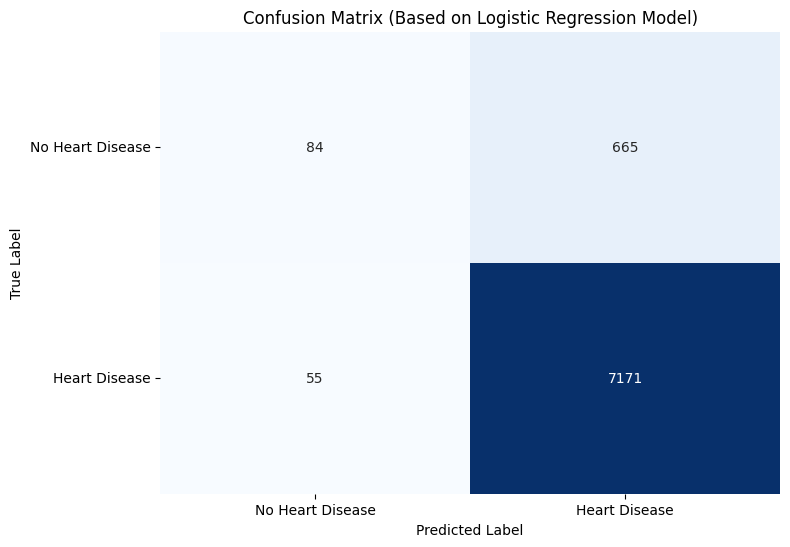

In [ ]:
# Predict the target values based on the best estimator found by GridSearchCV
y_test_pred = logistic_grid_search.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Based on Logistic Regression Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'], rotation=0)
plt.show()

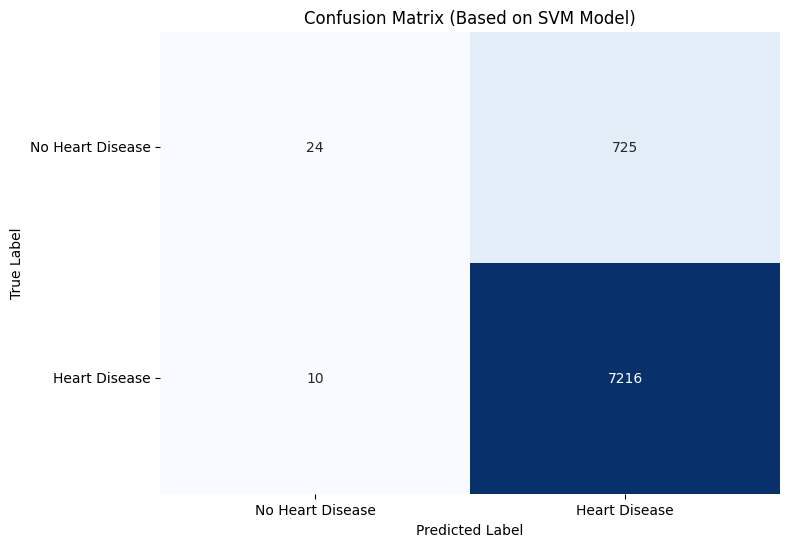

In [ ]:
# Predict the target values based on the best estimator found by GridSearchCV
y_test_pred = svm_grid_search.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Based on SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Heart Disease', 'Heart Disease'], rotation=0)
plt.show()

#### Creating Polynomial Features (Feature Engineering)

In [ ]:
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.feature_selection import SelectFromModel

# Create interaction / polynomial features
#poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
#X_poly = poly.fit_transform(X_train)

In [ ]:
# Logistic Regression Pipeline with SelectFromModel
#logistic_pipeline = Pipeline(steps=[
    #('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    #('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
    #('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler()),
    #('model', LogisticRegression(max_iter=1000, random_state=42))
#])

# SVM Pipeline with SelectFromModel
#svm_pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    #('feature_selection', SelectFromModel(SVC(kernel='linear', C=0.01))),  # Linear kernel and a small C for feature selection
    #('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler()),
    #('model', SVC(kernel='rbf', random_state=42))  # Final SVM model
#])

# XGBoost Pipeline with SelectFromModel
#xgb_pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    #('feature_selection', SelectFromModel(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))),
    #('imputer', SimpleImputer(strategy='mean')),
    #('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))  # Final XGBoost model
#])


# Random Forest Pipeline with SelectFromModel
#rf_pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    #('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    #('imputer', SimpleImputer(strategy='mean')),
    #('model', RandomForestClassifier(n_estimators=100, random_state=42))  # Final Random Forest model
#])

In [ ]:
#logistic_param_grid = {
    #'feature_selection__estimator__C': [0.01, 0.1, 1, 10, 100], # hyperparameters for the logistic regression model used in SelectFromModel
    #'model__C': [0.01, 0.1, 1, 10, 100],
    #'model__penalty': ['l2'],
    #'model__solver': ['saga'],
    #'model__max_iter': [100, 1000, 5000]
#}

#svm_param_grid = {
    #'model__C': [1, 10],  # Reduced range of C values
    #'model__gamma': ['scale', 0.01],  # Limited gamma to 'scale' and a representative value
    #'model__kernel': ['rbf'],  # Focus on the RBF kernel, often the best choice for SVM
    # Removed 'model__degree': Typically, 'poly' kernel requires more processing time
#}

#xgb_param_grid = {
    #'model__max_depth': [5, 7],  # Focused on mid-range depths
    #'model__n_estimators': [100, 200],  # Reduced the upper range
    #'model__learning_rate': [0.1],  # Chose a commonly effective rate
    #'model__subsample': [0.7, 1.0],  # Limited to higher subsampling for variance reduction
    #'model__colsample_bytree': [0.7],  # Chose a moderate value for feature sampling
    #'model__gamma': [0, 0.1]  # Simplified to two options to evaluate regularization benefit
#}

#rf_param_grid = {
    #'model__n_estimators': [100, 200],  # Reduced number of trees options
    #'model__max_depth': [10, 20],  # Focus on moderate to high depth to control complexity
    #'model__min_samples_split': [2, 5],  # Simplified range for minimum number of samples required to split
    #'model__min_samples_leaf': [1, 2],  # Reduced range for the minimum number of samples required at a leaf node
    #'model__max_features': ['auto'],  # Use the default option for the number of features to consider when looking for the best split
    #'model__bootstrap': [True]  # Keep bootstrapping enabled for better generalization
    # Removed 'model__criterion': Simplification, sticking with the default 'gini' criterion
}

In [ ]:
# Logistic Regression GridSearchCV
#logistic_grid_search = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5, scoring='accuracy')
#logistic_grid_search.fit(X_train, y_train) # No need to transform X_train as pipeline will handle it

# Best parameters and CV score
#print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)
#print("Best CV score for Logistic Regression:", logistic_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
#y_train_pred = logistic_grid_search.predict(poly.transform(X_train))
#train_accuracy = accuracy_score(y_train, y_train_pred)
#print("Train accuracy for Logistic Regression:", train_accuracy)

#y_test_pred = logistic_grid_search.predict(poly.transform(X_test))
# Evaluate on test data using the best estimator found by GridSearchCV
#y_test_pred = logistic_grid_search.predict(poly.transform(X_test))
#test_accuracy = accuracy_score(y_test, y_test_pred)
#print("Test accuracy for Logistic Regression:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
#best_index1 = logistic_grid_search.best_index_
#mean_cv_score = logistic_grid_search.cv_results_['mean_test_score'][best_index1]
#std_cv_score = logistic_grid_search.cv_results_['std_test_score'][best_index1]
#print(f"Mean CV score for the best Logistic Regression model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


In [ ]:
# SVM GridSearchCV
#svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy')
#svm_grid_search.fit(X_train, y_train)

# Best parameters and score
#print("Best parameters for SVM:", svm_grid_search.best_params_)
#print("Best score for SVM:", svm_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
#y_train_pred = svm_grid_search.predict(X_train)
#train_accuracy = accuracy_score(y_train, y_train_pred)
#print("Train accuracy for SVM", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
#y_test_pred = svm_grid_search.predict(X_test)
#test_accuracy = accuracy_score(y_test, y_test_pred)
#print("Test accuracy for SVM:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
#best_index = svm_grid_search.best_index_
#mean_cv_score = svm_grid_search.cv_results_['mean_test_score'][best_index]
#std_cv_score = svm_grid_search.cv_results_['std_test_score'][best_index]
#print(f"Mean CV score for the best SVM model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

In [ ]:
# XGBoost GridSearchCV
#xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy')
#xgb_grid_search.fit(X_train, y_train)

# Best parameters and score
#print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
#print("Best score for XGBoost:", xgb_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
#y_train_pred = xgb_grid_search.predict(X_train)
#train_accuracy = accuracy_score(y_train, y_train_pred)
#print("Train accuracy for XGBoost:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
#y_test_pred = xgb_grid_search.predict(X_test)
#test_accuracy = accuracy_score(y_test, y_test_pred)
#print("Test accuracy for XGBoost:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
#best_index = xgb_grid_search.best_index_
#mean_cv_score = xgb_grid_search.cv_results_['mean_test_score'][best_index]
#std_cv_score = xgb_grid_search.cv_results_['std_test_score'][best_index]
#print(f"Mean CV score for the best XGBoost model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


In [ ]:
# Random Forest GridSearchCV
#rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')
#rf_grid_search.fit(X_train, y_train)

# Best parameters and score
#print("Best parameters for Random Forest:", rf_grid_search.best_params_)
#print("Best score for Random Forest:", rf_grid_search.best_score_)

# Evaluate on training data using the best estimator found by GridSearchCV
#y_train_pred = rf_grid_search.predict(X_train)
#train_accuracy = accuracy_score(y_train, y_train_pred)
#print("Train accuracy for Random Forest:", train_accuracy)

# Evaluate on test data using the best estimator found by GridSearchCV
#y_test_pred = rf_grid_search.predict(X_test)
#test_accuracy = accuracy_score(y_test, y_test_pred)
#print("Test accuracy for Random Forest:", test_accuracy)

# If you want to report the CV scores detail for the best model, you can do it by accessing cv_results_
# Here's how to get the mean CV score for the best estimator across folds
#best_index = rf_grid_search.best_index_
#mean_cv_score = rf_grid_search.cv_results_['mean_test_score'][best_index]
#std_cv_score = rf_grid_search.cv_results_['std_test_score'][best_index]
#print(f"Mean CV score for the best Random Forest model: {mean_cv_score:.4f} ± {std_cv_score:.4f}")


In [ ]:
# Confusion matrix values
TN = 4116
FP = 0
FN = 510
TP = 0

# Calculate the total number of predictions
total_predictions = np.sum([TN, FP, FN, TP])

# Calculate the percentages using numpy for consistency
TP_percentage = np.round((TP / total_predictions) * 100, 2)
TN_percentage = np.round((TN / total_predictions) * 100, 2)
FP_percentage = np.round((FP / total_predictions) * 100, 2)
FN_percentage = np.round((FN / total_predictions) * 100, 2)

# Print the results
print(f"True Positives Percentage: {TP_percentage}%")
print(f"True Negatives Percentage: {TN_percentage}%")
print(f"False Positives Percentage: {FP_percentage}%")
print(f"False Negatives Percentage: {FN_percentage}%")

True Positives Percentage: 0.0%
True Negatives Percentage: 88.98%
False Positives Percentage: 0.0%
False Negatives Percentage: 11.02%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming svm_grid_search and X_test are already defined and svm_grid_search has been fitted
y_pred = svm_grid_search.best_estimator_.predict(X_test)

# Calculate precision, recall, F1 score, and ROC AUC score
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred)  # Ensure y_test and y_pred are appropriately prepared

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Precision: 0.7059
Recall: 0.0320
F1 Score: 0.0613
ROC AUC Score: 0.5153


In [ ]:
# Predict probabilities for the positive class
y_pred_prob = svm_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score using predicted probabilities
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

AttributeError: predict_proba is not available when  probability=False